In [ ]:
import os.path

import cv2  # opencv import
import numpy as np
import requests

# Download YOLO net config file
# We'll it from the YOLO author's github repo
yolo_config = 'yolov3.cfg'
if not os.path.isfile(yolo_config):
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
  r = requests.get(url)
  with open(yolo_config, 'wb') as f:
    f.write(r.content)

# Download YOLO net weights
# We'll it from the YOLO author's website
yolo_weights = 'yolov3.weights'
if not os.path.isfile(yolo_weights):
    url = 'https://pjreddie.com/media/files/yolov3.weights'
    r = requests.get(url)
    with open(yolo_weights, 'wb') as f:
        f.write(r.content)

# load the network
net = cv2.dnn.readNet(yolo_weights, yolo_config)

In [ ]:
# Download class names file
# Contains the names of the classes the network can detect
classes_file = 'coco.names'
if not os.path.isfile(classes_file):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
    r = requests.get(url)
    with open(classes_file, 'wb') as f:
        f.write(r.content)

# load class names
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

# Download object detection image
image_file = 'test01.png'
"""
if not os.path.isfile(image_file):
    url = "https://github.com/ivan-vasilev/advanced-deep-learning-with-python/blob/master/chapter04-detection-segmentation/source_1.png"
    r = requests.get(url)
    with open(image_file, 'wb') as f:
        f.write(r.content)
"""
print()

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']



In [ ]:
image_file = "test01.png"
image_file = "test01.jpg"

# read and normalize image
image = cv2.imread(image_file)
print( type(image) )
blob = cv2.dnn.blobFromImage(image, 1 / 255, (416, 416), (0, 0, 0), True, crop=False)
print( type(blob) )
print( blob.shape )

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1, 3, 416, 416)


In [ ]:
# set as input to the net
net.setInput(blob)

# get network output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(output_layers)

# inference
# the network outputs multiple lists of anchor boxes,
# one for each detected class
outs = net.forward(output_layers)
#print( outs )


['yolo_82', 'yolo_94', 'yolo_106']


In [ ]:
print( len(outs) )
print()
print( len(outs[0]) )
print( len(outs[1]) )
print( len(outs[2]) )
print()
print( len(outs[0][0]) )
print( len(outs[1][0]) )
print( len(outs[2][0]) )

3

507
2028
8112

85
85
85


In [ ]:
# extract bounding boxes
class_ids = list()
confidences = list()
boxes = list()

count = 0
tmp = set()
# iterate over all classes
for out in outs:
  count = count + 1
  # iterate over the anchor boxes for each class
  for detection in out:
    # bounding box
    center_x = int(detection[0] * image.shape[1])
    center_y = int(detection[1] * image.shape[0])
    w, h = int(detection[2] * image.shape[1]), int(detection[3] * image.shape[0])
    x, y = center_x - w // 2, center_y - h // 2
    boxes.append([x, y, w, h])

    # confidence
    confidences.append(float(detection[4]))
    # class
    class_ids.append(np.argmax(detection[5:]))

print( tmp )
print( len(class_ids) )
print( len(confidences) )
print( len(boxes) )

set()
10647
10647
10647


In [ ]:
# non-max suppression
ids = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.75, nms_threshold=0.5)

print(type(ids))
print( len(ids) )
print(ids)

for i in ids:
  i = i[0]
  #print(i)
  class_id = class_ids[i]
  print( classes[class_id] )

<class 'numpy.ndarray'>
1
[[254]]
elephant


In [ ]:
# draw the bounding boxes on the image
colors = np.random.uniform(0, 255, size=(len(classes), 3))
print( colors.shape )

for i in ids:
  i = i[0]
  x, y, w, h = boxes[i]
  class_id = class_ids[i]
  color = colors[class_id]
  cv2.rectangle(img=image,
              pt1=(round(x), round(y)),
              pt2=(round(x + w), round(y + h)),
              color=color,
              thickness=3)
  cv2.putText(img=image,
            text=f"{classes[class_id]}: {confidences[i]:.2f}",
            org=(x - 10, y - 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.8,
            color=color,
            thickness=2)

(80, 3)


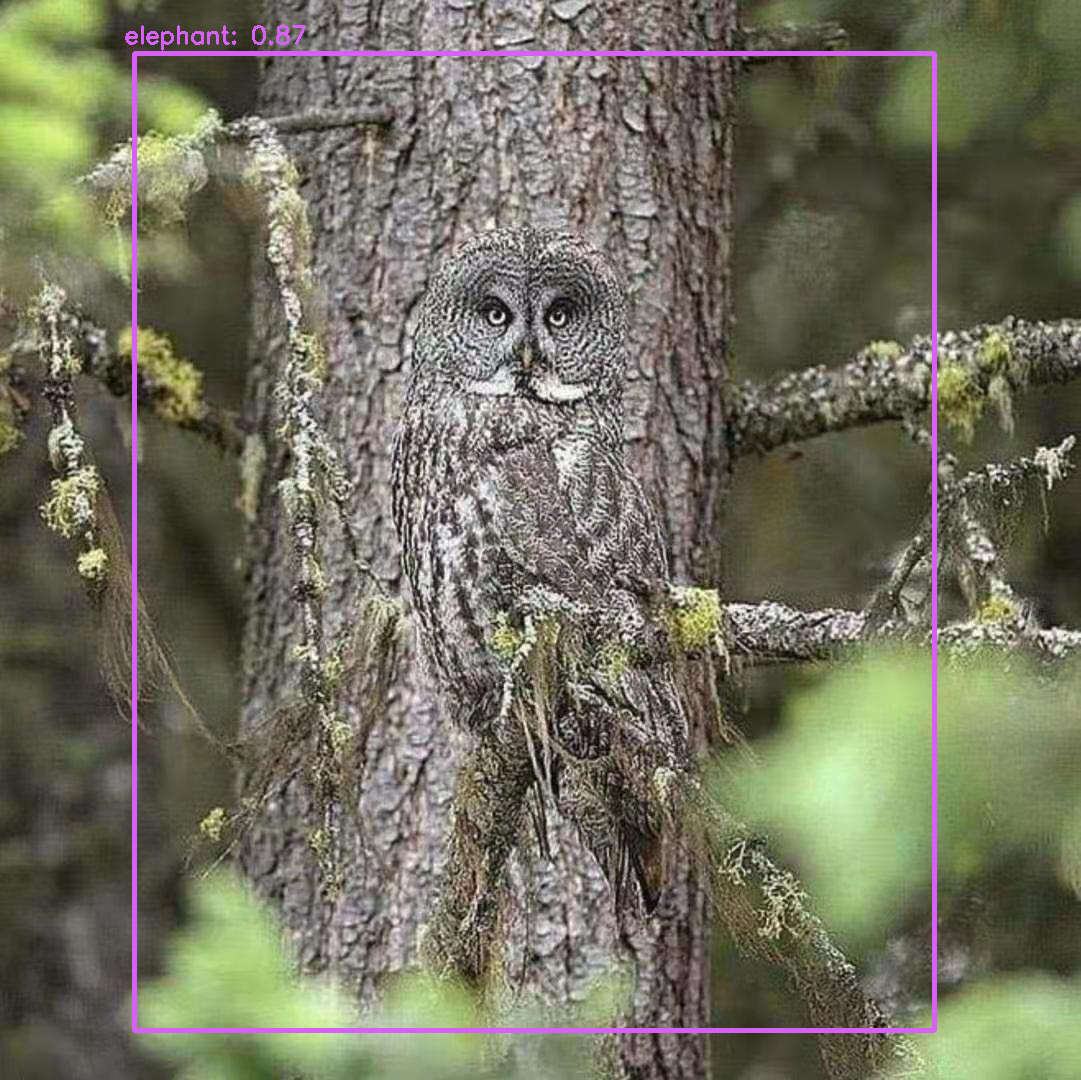

In [ ]:
from google.colab.patches import cv2_imshow
#cv2.imshow("Object detection", image)
#cv2.waitKey()
cv2_imshow(image)

In [ ]:
# Faster R-CNN object detection

In [ ]:
import os.path

import cv2
import numpy as np
import requests
import torchvision
import torchvision.transforms as transforms

classes = [
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack',
    'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk',
    'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']

# load the pytorch model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# set the model in evaluation mode
model.eval()

In [ ]:
# read the image file
image_file = "test01.jpg"

img = cv2.imread(image_file)

# transform the input to tensor
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
nn_input = transform(img)
output = model([nn_input])

# random color for each class
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# iterate over the network output for all boxes
for box, box_class, score in zip(output[0]['boxes'].detach().numpy(),
                                 output[0]['labels'].detach().numpy(),
                                 output[0]['scores'].detach().numpy()):
    # filter the boxes by score
    if score > 0.5:
        # transform bounding box format
        box = [(box[0], box[1]), (box[2], box[3])]

        # select class color
        color = colors[box_class]

        # extract class name
        class_name = classes[box_class]
        print( class_name )
        # draw the bounding box
        cv2.rectangle(img=img,
                  pt1=box[0],
                  pt2=box[1],
                  color=color,
                  thickness=2)

        # display the box class label
        cv2.putText(img=img,
                  text=class_name,
                  org=box[0],
                  fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                  fontScale=1,
                  color=color,
                  thickness=2)

bird


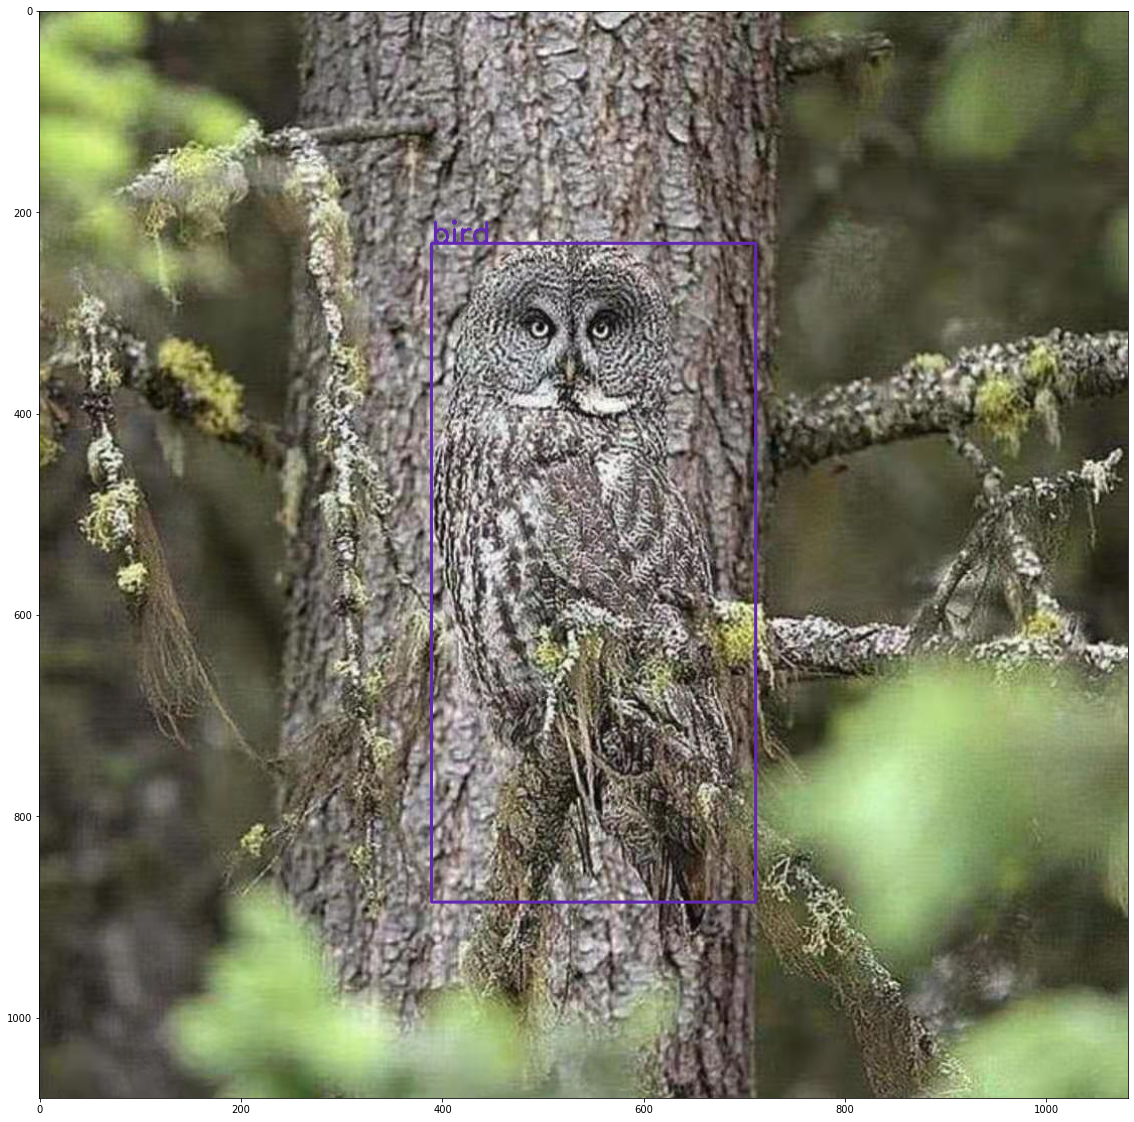

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))